# Word Embeddings Text Classification with LSTMs

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Word-Embeddings-Text-Classification-with-LSTMs" data-toc-modified-id="Word-Embeddings-Text-Classification-with-LSTMs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Word Embeddings Text Classification with LSTMs</a></span></li><li><span><a href="#Prepping-the-data" data-toc-modified-id="Prepping-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepping the data</a></span></li><li><span><a href="#Implementing-the-model" data-toc-modified-id="Implementing-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementing the model</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Inference" data-toc-modified-id="Inference-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Inference</a></span></li></ul></li><li><span><a href="#Resources" data-toc-modified-id="Resources-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Resources</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Resources-to-understand-the-embedding-layer" data-toc-modified-id="Resources-to-understand-the-embedding-layer-4.0.0.1"><span class="toc-item-num">4.0.0.1&nbsp;&nbsp;</span>Resources to understand the embedding layer</a></span></li></ul></li></ul></li></ul></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
import tensorflow as tf
from utils import f1

# Prepping the data

In [2]:
df = pd.read_csv("train.csv",usecols=["text","target"]);df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
# We need a token for words that are not in the vocabulary for the model to distinguish.
oov_tok = "<OOV>"

# Now we need to create a tokenizer to convert sentences into sequences of integers.
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(df.text) 

In [8]:
word_index = tokenizer.word_index
vocab_size = len(word_index)
print("Vocabulary size is",vocab_size)

Vocabulary size is 22701


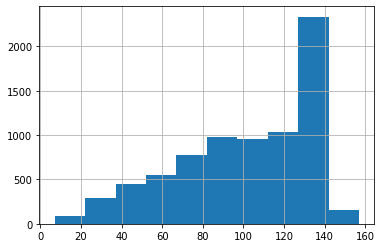

In [4]:
# Lets plot a historgram to decide on the maximum sequence length

df.text.apply(len).hist()
# Y axis is the frequency
# X axis is the sentence length



In [9]:
max_length = 150 # Most sequences are smaller than 150.
sequences = tokenizer.texts_to_sequences(df.text) # Now the sentences are converted to integers

# In order to make all batches the same length we need the senteces to be the same length.
# To accomplish this we pad sentences (inputs) from the right.
padding_type='post'
# Some of the sentences are longer than the sequence length we specified, 
# so we have to truncate the sequences.
trunc_type = 'post'

padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

In [13]:
idx = 1
print("Sequence before padding",sequences[idx])
print("Sequence after padding",padded[idx])

Sequence before padding [190, 46, 230, 800, 6955, 6956, 1405]
Sequence after padding [ 190   46  230  800 6955 6956 1405    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [14]:
# We can not split the data into train and test.
# The models will take sequences of integers are input and output 1 or 0.

X_train,X_test,y_train,y_test = train_test_split(padded,df.target, random_state = 0)
X_train.shape,X_test.shape

((5709, 150), (1904, 150))

# Implementing the model

In [66]:
embedding_dim = 100 # This is a hyperparameter we can play with
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['acc',f1])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 100)          2270200   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                34048     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 2,312,697
Trainable params: 2,312,697
Non-trainable params: 0
_________________________________________________________________


## Training

In [67]:
num_epochs = 3
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)

print("Training Complete")

Epoch 1/3
179/179 [==============================] - 9s 50ms/step - loss: 0.5423 - acc: 0.7234 - f1: 0.5361 - val_loss: 0.4400 - val_acc: 0.8036 - val_f1: 0.7156
Epoch 2/3
179/179 [==============================] - 8s 44ms/step - loss: 0.2758 - acc: 0.8891 - f1: 0.8600 - val_loss: 0.4737 - val_acc: 0.7962 - val_f1: 0.7485
Epoch 3/3
179/179 [==============================] - 8s 44ms/step - loss: 0.1221 - acc: 0.9587 - f1: 0.9497 - val_loss: 0.6082 - val_acc: 0.7810 - val_f1: 0.7356
Training Complete


## Inference

In [63]:
from sklearn.metrics import classification_report
preds = model.predict_classes(X_test)
print(classification_report(y_test,preds))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1107
           1       0.76      0.71      0.74       797

    accuracy                           0.79      1904
   macro avg       0.78      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904



# Resources

#### Resources to understand the embedding layer

https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
https://www.kaggle.com/rajmehra03/a-detailed-explanation-of-keras-embedding-layer